# Package: 
Git: https://github.com/demosgill/sumOfExponentials

import sumOfExponentials.soe_clean as soec

In [1]:
from IPython.core.display import HTML4
HTML('<a href="https://imgflip.com/gif/1cytzj"><img src="https://i.imgflip.com/1cytzj.gif" title="made at imgflip.com"/></a>')

ImportError: cannot import name HTML4

In [20]:
import soe_clean as soec
import soe_gamma2 as soec2
import soe_gamma3 as soec3

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%pylab inline
import itertools as itertools
from scipy.optimize import minimize

/Users/demos/anaconda/lib/python2.7/site-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


Populating the interactive namespace from numpy and matplotlib


# Start
    
 The model reads:
 $Y_t = A exp^{(-\gamma_1 t)} + B exp^{(-\gamma_2 t)} + C exp^{(-\gamma_3 t)} \label{one}$
 
 Enslaving the linear parameters unto the non-linears one yield the following optimisation problem:
 
 $(\hat{\gamma_1}, \hat{\gamma_2}, \hat{\gamma_3}) = arg. max._{A,B,C} L(\gamma_1, \gamma_2, \gamma_3)$ 
 
 The linear parameters are in turn obtained by solving the following set of linear equations:

$
\begin{equation}
  \left(\begin{array}{ccc}
    \sum f_i^2 & \sum f_i g_i & \sum f_i h_i \\
     \sum f_i g_i & \sum g_i^2 & \sum g_i h_i \\
    \sum f_i h_i &  \sum g_i h_i  & \sum h_i^2 \\
  \end{array}\right)\left(\begin{array}{c}
    \hat A\\ \hat B\\ \hat C  
  \end{array}\right)=
  \left(\begin{array}{c} 
    \sum y_if_i \\ \sum y_ig_i \\ \sum y_ih_i \\ 
  \end{array}\right)
\end{equation}
$

where: $f_i = exp^{(-\gamma_1 t)}$, $g_i = exp^{(-\gamma_2 t)}$, $h_i = exp^{(-\gamma_3 t)}$.

# Estimation procedure:
    Grid search:
        - 5 Random starting points for NL-parameters from [0.01 : 1.]  
        
        - 'Nelder-Mead' Simplex algorithm
    
# Synthetic data used:
    Input parameters are: [A=.2, B=.3, C=.4, g1=.3, g2=.15, g3 = .075]

    Sample size is defined by N; (N=25 for initial examples)

    We add gaussian noise $\sim (\mu, 0.01)$

In [24]:
# {pormenores estimation}
soec = reload(soec)
pars = np.array([.2, .3, .4, .3, .15, .075])
sampleSize = 25

# Simulate
sData = soec.simulate2(pars, sampleSize)

# Estimate QML
ParsQml, _, _ = soec.fitBest(sData)

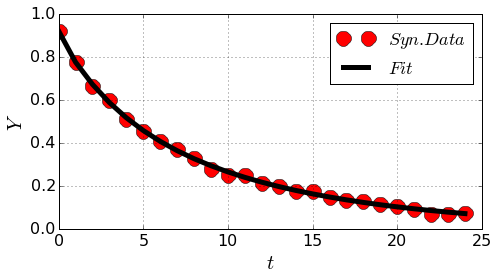

In [110]:
f, ax = plt.subplots(1,1,figsize=(7,4))
plt.plot(sData, marker='o', linestyle='', markersize=15, color='r')
sDa = soec.simulate2(ParsQml, sampleSize, noise=False)
plt.plot(sDa, color='k', linewidth=5)
plt.ylabel('$Y$', fontsize=20)
plt.xlabel('$t$', fontsize=20)
plt.legend([r'$Syn.Data$',r'$Fit$'], fontsize=18)
plt.grid()
plt.tight_layout()

# Profiling $\gamma_1$

In [37]:
# Estimate profile likelihood 
soec = reload(soec)
lpDf, lpHat, sGammaLp = soec.profilingGammaOne(sData)

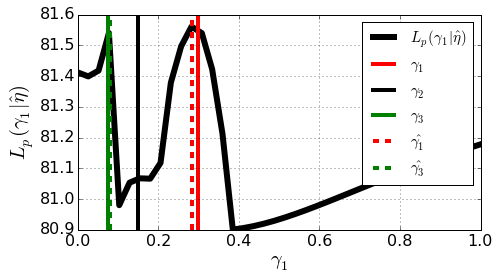

In [107]:
# plot
f, ax = plt.subplots(1,1,figsize=(7,4))
lpDf.plot(ax=ax, linewidth=6, color='k')

# True
plt.axvline(pars[3],linewidth=4, color='r')
plt.axvline(pars[4],linewidth=4, color='k')
plt.axvline(pars[5],linewidth=4, color='g')

# Estimated
plt.axvline(lpHat[3],linewidth=4, color='r', linestyle='--')
plt.axvline(lpHat[4],linewidth=4, color='g', linestyle='--')

# Legend
plt.legend([r'$L_p(\gamma_1|\hat{\eta})$','$\gamma_1$', '$\gamma_2$',
            '$\gamma_3$',r'$\hat{\gamma_1}$',r'$\hat{\gamma_3}$'], fontsize=15)
plt.xlabel(r'$\gamma_1$', fontsize=20)
plt.ylabel('$L_p(\gamma_1|\hat{\eta})$', fontsize=20)
plt.grid()
plt.tight_layout()

# True parameters are:
    A, B, C, g1, g2, g3 = [ 0.2    0.3    0.4    0.3    0.15   0.075]
    
# Estimated parameters are:
    A, B, C, g1, g2, g3 = [0.36, 0.55, 0.00, 0.28, 0.08, -0.19]

# Understanding this Phenomena:
Only the first two terms are estimated, i.e. only these terms matter for fitting the data (A,B,g1,g2):

$Y_t = A exp(\gamma_1 t) + B exp(\gamma_2 t)$, 

since C = 0 and thus g3 is unimportant.
        

# Modified Profile Likelihood $\gamma_1$

In [112]:
# Get hessian and Jacobian
H, J = soec.hessianForGivenGammaOne(pars, sData, 0.1)

# H has a super small determinant:
$\rightarrow$ ill-conditioned

In [113]:
# Calculate the determinant
np.linalg.det(H)

2.2700848558949395e-154

# Checking the structure of the reduced Hessian and $\lambda$

In [125]:
# Hessian
pd.DataFrame(H,columns=['A','B','C','g2','g3'],
            index=['A','B','C','g2','g3'])

,A,B,C,g2,g3
A,1.095897e+01,-9.805658e-14,-7.645963e-14,-1.840740e-13,-3.557288e-13
B,-9.805658e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C,-7.645963e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
g2,-1.840740e-13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
g3,-3.557288e-13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [122]:
# Eigenvalues and Eigenvectors
evals, evecs = np.linalg.eig(H)
pd.DataFrame(evecs, index=evals, columns=['A','B','C','g2','g3'])

,A,B,C,g2,g3
1.095897e+01,1.000000e+00,-3.826905e-14,-7.473183e-48,3.387211e-47,-9.893765e-51
-1.604963e-26,-8.947610e-15,-2.338080e-01,-1.823118e-01,-4.389097e-01,-8.482067e-01
0.000000e+00,-6.976900e-15,-1.823118e-01,9.730610e-01,-6.485484e-02,-1.253340e-01
0.000000e+00,-1.679665e-14,-4.389097e-01,-6.485484e-02,8.438641e-01,-3.017375e-01
0.000000e+00,-3.246006e-14,-8.482067e-01,-1.253340e-01,-3.017375e-01,4.168829e-01


# Modified Profile:
    - Profiling from: 0.001 to 1. using 25 points

In [10]:
# preliminares
soec = reload(soec)
pars = np.array([.2, .3, .4, .3, .15, .075])
sampleSize = 20

# Simulate
sData = soec.simulate2(pars, sampleSize)

# Esimate Lp and Lmp
%time lpDf, mplDf, lpHat, lmpHat = soec.LpAndMlpOptimising(sData)

CPU times: user 3min 36s, sys: 719 ms, total: 3min 36s
Wall time: 26min 43s


# Explain the metric used for comparing estimatores

## N = 5

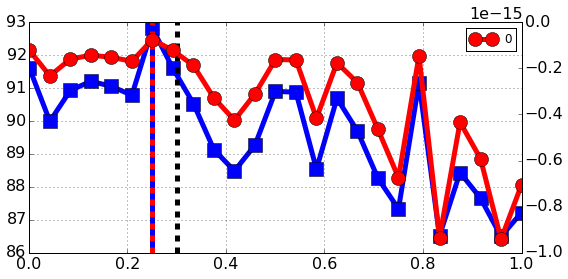

In [5]:
soec.compareLpAndLmp(lpDf, mplDf, lpHat, lmpHat, pars)

## N = 15

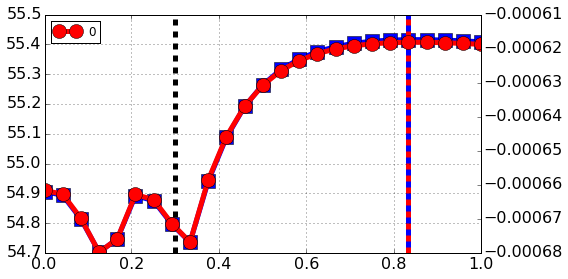

In [9]:
soec.compareLpAndLmp(lpDf, mplDf, lpHat, lmpHat, pars)

## N = 20

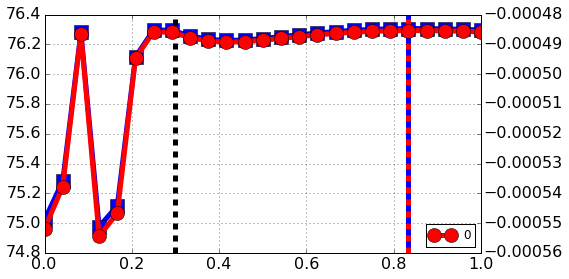

In [11]:
soec.compareLpAndLmp(lpDf, mplDf, lpHat, lmpHat, pars)

## N = 25

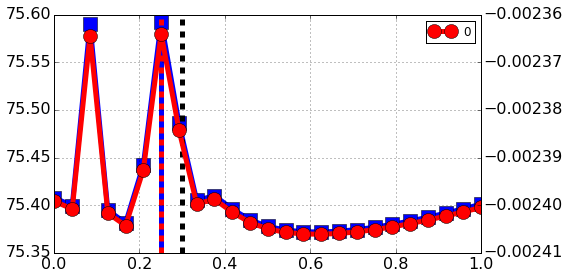

In [71]:
soec = reload(soec)
soec.compareLpAndLmp(lpDf, mplDf, lpHat, lmpHat, pars)

In [72]:
pars

array([ 0.2  ,  0.3  ,  0.4  ,  0.3  ,  0.15 ,  0.075])

# Example of the cost function used on the MC simulation study to compare performance of distinct estimators: 
- 1 singe realization for a single fixed sample size

In [6]:
import brutusRun as br
br = reload(br)
pars = np.array([.2, .3, .4, .3, .15, .075])
sampleSize = 15
MC = 1
C1, C2, C3 = br.simulateAndEstimateViaAllEstimators(pars, sampleSize, MC)

In [7]:
C1

,15
0,1.420829


In [8]:
C2

,15
0,1.404796


In [9]:
C3

,15
0,1.404796


# Example of the cost function used on the MC simulation study to compare performance of distinct estimators: 
- 100 realizations per sample size. Sample size = 73 sub-samples $\in [5, 70]$

In [246]:
path = '/Users/demos/bigdata/resultsMonteCarloSoe/'
fold = ['lp/','qml/','mpl/']
soec = reload(soec)

# Getting data
reLp  = soec.fsl.get_all_files_from_a_folder(path+fold[0])
reQml = soec.fsl.get_all_files_from_a_folder(path+fold[1])
reMpl = soec.fsl.get_all_files_from_a_folder(path+fold[2])

# Removing outliers ??
reLp  = reLp[reLp < 10**44.].T
reMpl = reMpl[reMpl < 10**44.].T
reQml = reQml[reQml < 10**44.].T

# sorting index
reLp.index  = reLp.index.astype(int)
reLp = reLp.sort_index(ascending=True)

reMpl.index = reMpl.index.astype(int)
reMpl = reMpl.sort_index(ascending=True)

reQml.index = reQml.index.astype(int)
reQml = reQml.sort_index(ascending=True)

## Visualizing results

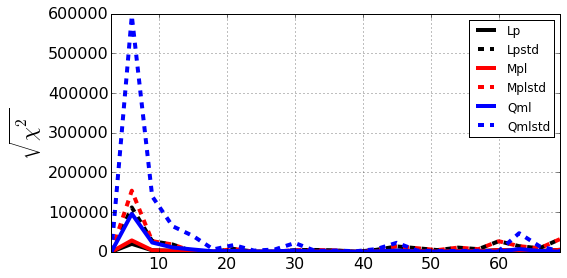

In [250]:
lw = 4


stdQml = reQml.std(axis=1)
stdMpl = reMpl.std(axis=1)

f,ax = plt.subplots(1,1,figsize=(8,4))
np.sqrt(reLp.mean(axis=1)).plot(linewidth=lw, color='k')
np.sqrt(stdLp).plot(linewidth=lw, linestyle='--', color='k')

np.sqrt(reMpl.mean(axis=1)).plot(linewidth=lw, color='r')
np.sqrt(stdMpl).plot(linewidth=lw, linestyle='--', color='r')

np.sqrt(reQml.mean(axis=1)).plot(linewidth=lw, color='b')
np.sqrt(stdQml).plot(linewidth=lw, linestyle='--', color='b')

ax.legend(['Lp','Lpstd','Mpl','Mplstd','Qml','Qmlstd'])

plt.ylabel(r'$\sqrt{\chi^2}$',fontsize=22)
plt.grid()
plt.tight_layout()

# Ive ran new simulations. Compile results asap

# ETAS model

# 

The ETAS model is a special case of the marked Hawkes-type self-exciting process and has the following specific expression for conditional intensity:

$\lambda_\theta(t|H_t)= \mu + \sum_{i:S<t_i<t}\frac{K_0 e^{\alpha(M_i - M_z)}}{(t-t_i+c)^p}$

where:

$S$ is the stating time of earthquake observation;

$M_z$ represents the smallest magnitude of earthquakes to be treated in the data set. 

$M_i$ and $t_i$ represent the magnitude and the occurrence time of the $i$-th earthquake, respectively and

$H_t$ := occurrence series of the set ($t_i, M_i$) before time t. 

The parameter set $\theta$ thus consists of $(\mu, K_0, c, \alpha, p)$.

In [335]:
import sys
import random
from math import exp, log

import numpy as np


def gen_etas_seq(t_end, mu, k, c, alpha, p, mr, tau, mag_fn):
    """ETAS event sequence"""
    assert t_end > 0
    assert mu > 0
    assert k >= 0
    assert c > 0
    assert tau > 0
    mu_tau = mu/tau
    k_tau = k/_omori_integrate(tau, c, p)
    parent = 0
    current = parent
    queue = []
    for _ in range(_n_events(mu_tau*t_end)):
        t = t_end*random.random()
        m = mag_fn()
        current += 1
        pair = (t, m, current, parent)
        yield pair
        queue.append(pair)
    for t_parent, m_parent, parent, _ in queue:
        tail_size = _omori_integrate(t_end - t_parent, c, p)
        coeff = k_tau*exp(alpha*(m_parent - mr))
        n_expect = coeff*tail_size
        for _ in range(_n_events(n_expect)):
            integ = tail_size*(1 - random.random()) # should not be 0
            t = _omori_time(integ, c, p) + t_parent
            assert t <= t_end
            m = mag_fn(m_parent)
            current += 1
            pair = (t, m, current, parent)
            yield pair
            queue.append(pair)


_log10 = log(10)

def random_gr(b, m_min, m_max=sys.float_info.max):
    """return: [m_min, m_max)
    """
    assert m_min < m_max
    b_log10 = b*_log10
    return -1/b_log10*log(exp(-b_log10*m_min) -
                          (1 - random.random())*
                          (exp(-b_log10*m_min) -
                           exp(-b_log10*m_max)))

def _n_events(n):
    return np.random.poisson(n)


def _omori_time(integ, c, p):
    """_omori_integrate(ret, c, p) == integ
    """
    if p == 1:
        return c*(exp(integ) - 1)
    else:
        return (integ*(1 - p) + c**(1 - p))**(1/(1 - p)) - c


def _omori_integrate(t, c, p):
    """$\int_{0}^{t} 1/(t + c)^{p}$
    """
    if p == 1:
        return log((t + c)/c)
    else:
        return ((t + c)**(1 - p) - c**(1 - p))/(1 - p)


def main(args):
    T = []
    t_end = 1000
    mu = 0.1
    k = 10
    c = 0.01
    alpha = 1.1
    p = 1.1
    mr = 6
    tau = 1
    mag_fn = lambda m=None: random_gr(1, 2.5, 7)
    for t, m, _, _ in gen_etas_seq(t_end, mu, k, c, alpha, p, mr, tau, mag_fn):
        print(t, '\t', m)
        T.append(m)
        
    return T


if __name__ == '__main__':
    main(sys.argv)

(269.7677297690497, '\t', 2.7192738539212886)
(141.58033241847411, '\t', 3.727408630565105)
(812.9505362731026, '\t', 2.9206077777653094)
(775.7374357345387, '\t', 2.5003234944603605)
(483.30010245003564, '\t', 2.8775993908590145)
(117.59242200589115, '\t', 3.1291445547939745)
(376.8307093241187, '\t', 2.6476232211746287)
(359.22093330762215, '\t', 2.5567391038133302)
(283.0630246447132, '\t', 2.8955624784697873)
(628.5670862371237, '\t', 2.93420291963479)
(713.3544569869015, '\t', 2.549742486429137)
(800.187182938037, '\t', 2.538052893569896)
(489.31454841574197, '\t', 2.8149336341011892)
(728.931356624796, '\t', 3.554859566140361)
(155.44290237414504, '\t', 2.510624371664292)
(914.8039950924513, '\t', 2.984772213344096)
(948.2129755398428, '\t', 2.856901226362313)
(656.5808471403772, '\t', 2.5865676292880537)
(901.1802936734153, '\t', 3.346521643059787)
(961.708124762586, '\t', 3.505837024766089)
(214.15471723543044, '\t', 2.5983628795330653)
(737.8889045243297, '\t', 2.6326509891144

In [336]:
r = main(sys.argv)

(966.9588068894083, '\t', 2.943225470138328)
(474.1712646262597, '\t', 2.7790846017160855)
(604.7613878894272, '\t', 3.4550835910160385)
(950.7045295820096, '\t', 3.364988528012526)
(9.176065920851627, '\t', 2.544827389191631)
(935.0676264214625, '\t', 2.6740829128126165)
(457.1844138626191, '\t', 4.346327789855498)
(273.4945763256624, '\t', 2.674959236174222)
(333.1892477669089, '\t', 2.880546028035959)
(33.74816921673074, '\t', 2.900028362610607)
(577.072016897444, '\t', 2.7639652448061827)
(862.9403232018262, '\t', 2.6564174161023066)
(430.2182146195055, '\t', 3.0176759995155917)
(389.8817984713651, '\t', 2.562757359960825)
(788.2560695416839, '\t', 2.651785947900474)
(607.9029169381978, '\t', 2.7582152511115825)
(458.44744156837004, '\t', 2.6580591202566137)
(281.4310916979257, '\t', 2.7976640695541923)
(684.4030856522846, '\t', 3.0600471315213738)
(970.8200473051529, '\t', 2.6593901116081735)
(905.5718760920475, '\t', 2.7830032277722663)
(751.3951826730707, '\t', 2.963591812438452

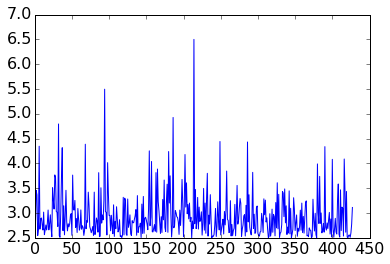

In [337]:
plt.plot(r)

# TODO:
    - Understand
    - Modify code
    - Upload github